In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import preprocess_kgptalkie as ps
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from prettytable import PrettyTable 

import warnings
warnings.filterwarnings("ignore")

/Users/atreish/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/atreish/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/atreish/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/atreish/opt/anaconda3/lib/python3.7/site-packages/tensorf

**Load IMDB Movie Review Dataset**

In [2]:
data = pd.read_csv('IMDB_Dataset.csv')

#What does our dataframe look like?
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
#How many reviews are there in total?
data.shape

(50000, 2)

In [4]:
#Are there any null or missing values?
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
#How many positive and negative? Is this data balanced?
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

**Data Cleaning / Text Preprocessing of Reviews**

In [6]:
#Special text cleaning function
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [7]:
#Apply the universal text cleaning function above to data, takes a while
data['review'] = data['review'].apply(lambda x: get_clean(x))

In [8]:
#Let's look at the cleaned review text data
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there is a family where a little boy...,negative
4,petter matteis love in the time of money is a ...,positive


In [9]:
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data.head(5)

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter matteis love time money visually stunni...,positive


**Define X and y for our Models**

In [10]:
X = data['review']
y = data['sentiment']

**Apply CountVectorizer**

In [11]:
countv = CountVectorizer()
#Vectorize X and generate a sparse matrix using CountVectorizer method
X1 = countv.fit_transform(X)

In [12]:
X1

<50000x219075 sparse matrix of type '<class 'numpy.int64'>'
	with 4900107 stored elements in Compressed Sparse Row format>

In [13]:
#Genderate the 80/20 split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=0)

#Does the split capture fairly even numbers of positive and negative?
print('Sentiment Training Set:\n\n{}'.format(y1_train.value_counts()))
print('\n\nSentiment Testing Set:\n\n{}'.format(y1_test.value_counts()))

Sentiment Training Set:

positive    20035
negative    19965
Name: sentiment, dtype: int64


Sentiment Testing Set:

negative    5035
positive    4965
Name: sentiment, dtype: int64


**Apply TF-IDF Vectorizer**

In [14]:
tfidf = TfidfVectorizer(max_features=10000)

#Vectorize X and generate a sparse matrix using Tf-IDF method
X = tfidf.fit_transform(X)

In [15]:
X

<50000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 4184389 stored elements in Compressed Sparse Row format>

In [16]:
#Genderate the 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Does the split capture fairly even numbers of positive and negative?
print('Sentiment Training Set:\n\n{}'.format(y_train.value_counts()))
print('\n\nSentiment Testing Set:\n\n{}'.format(y_test.value_counts()))

Sentiment Training Set:

positive    20035
negative    19965
Name: sentiment, dtype: int64


Sentiment Testing Set:

negative    5035
positive    4965
Name: sentiment, dtype: int64


**Logistic Regression Classifier using TFIDF**

In [17]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions_lr = logisticRegr.predict(X_test)
score_lr = logisticRegr.score(X_test, y_test)
cm_lr = metrics.confusion_matrix(y_test, predictions_lr)

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5035
    positive       0.88      0.90      0.89      4965

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



<Figure size 576x432 with 0 Axes>

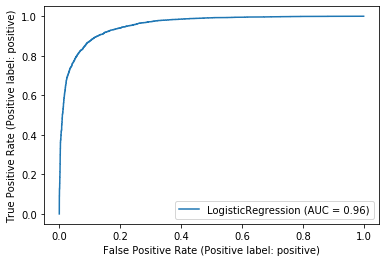

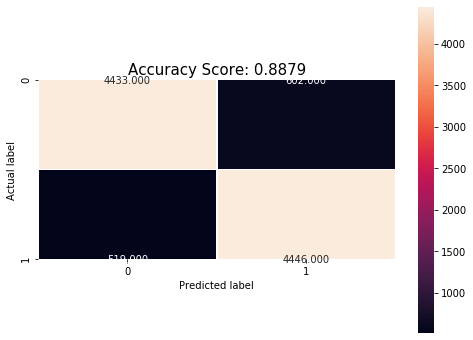

In [18]:
#Classification Report
print(classification_report(y_test, predictions_lr))

#ROC Curve
plt.figure(figsize=(8,6))
metrics.plot_roc_curve(logisticRegr, X_test, y_test) 
plt.show()

#Confusion Matrix of Results Classified by Logistic Regression
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt=".3f", linewidths=.5, square= True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_lr)
plt.title(all_sample_title, size = 15)
plt.show()

**Logistic Regression Classifier using CountVectorizer**

In [19]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X1_train, y1_train)
predictions_lr1 = logisticRegr.predict(X1_test)
score_lr1 = logisticRegr.score(X1_test, y1_test)
cm_lr1 = metrics.confusion_matrix(y1_test, predictions_lr1)

              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      5035
    positive       0.88      0.88      0.88      4965

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



<Figure size 576x432 with 0 Axes>

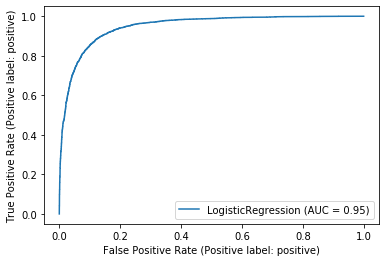

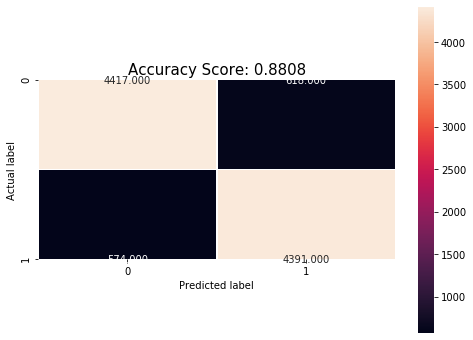

In [20]:
#Classification Report
print(classification_report(y1_test, predictions_lr1))

#ROC Curve
plt.figure(figsize=(8,6))
metrics.plot_roc_curve(logisticRegr, X1_test, y1_test) 
plt.show()

#Confusion Matrix of Results Classified by Logistic Regression
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr1, annot=True, fmt=".3f", linewidths=.5, square= True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_lr1)
plt.title(all_sample_title, size = 15)
plt.show()

**Multinomial Naive Bayes Classifier using TF-IDF**

In [21]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
predictions_mnb = mnb.predict(X_test)
score_mnb = mnb.score(X_test, y_test)
cm_mnb = metrics.confusion_matrix(y_test, predictions_mnb)

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      5035
    positive       0.85      0.85      0.85      4965

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



<Figure size 576x432 with 0 Axes>

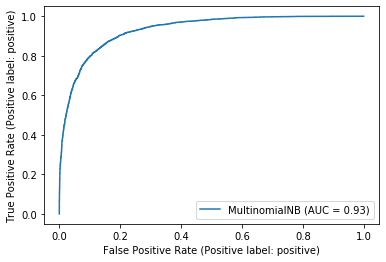

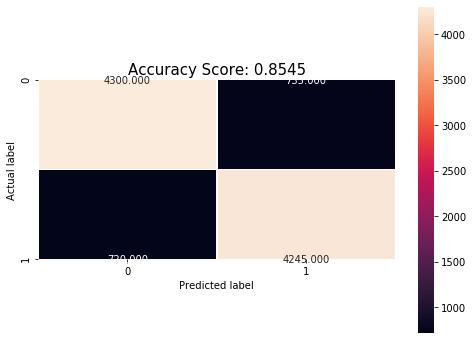

In [22]:
#Classification Report
print(classification_report(y_test, predictions_mnb))

#ROC Curve
plt.figure(figsize=(8,6))
metrics.plot_roc_curve(mnb, X_test, y_test) 
plt.show()

#Confusion Matrix of Results Classified by Multinomial Naive Bayes
plt.figure(figsize=(8,6))
sns.heatmap(cm_mnb, annot=True, fmt=".3f", linewidths=.5, square= True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_mnb)
plt.title(all_sample_title, size = 15)
plt.show()

**Multinomial Naive Bayes Classifier using CountVectorizer**

In [23]:
mnb = MultinomialNB()
mnb.fit(X1_train, y1_train)
predictions_mnb1 = mnb.predict(X1_test)
score_mnb1 = mnb.score(X1_test, y1_test)
cm_mnb1 = metrics.confusion_matrix(y1_test, predictions_mnb1)

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      5035
    positive       0.85      0.85      0.85      4965

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



<Figure size 576x432 with 0 Axes>

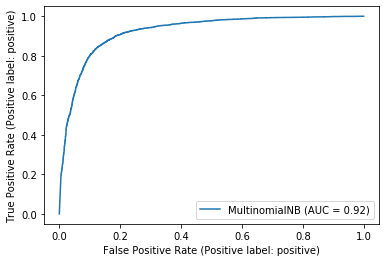

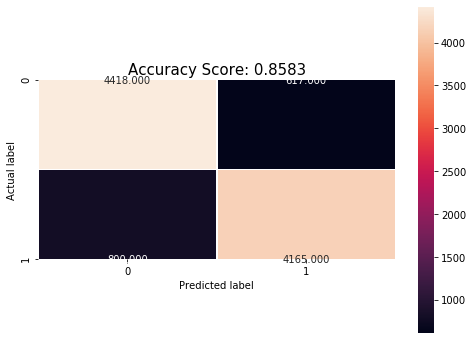

In [24]:
#Classification Report
print(classification_report(y1_test, predictions_mnb))

#ROC Curve
plt.figure(figsize=(8,6))
metrics.plot_roc_curve(mnb, X1_test, y1_test) 
plt.show()

#Confusion Matrix of Results Classified by Multinomial Naive Bayes
plt.figure(figsize=(8,6))
sns.heatmap(cm_mnb1, annot=True, fmt=".3f", linewidths=.5, square= True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_mnb1)
plt.title(all_sample_title, size = 15)
plt.show()

**LinearSVC Classifier using TF-IDF**

In [25]:
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
predictions_lsvc = lsvc.predict(X_test)
score_lsvc = lsvc.score(X_test, y_test)
cm_lsvc = metrics.confusion_matrix(y_test, predictions_lsvc)

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      5035
    positive       0.87      0.89      0.88      4965

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



<Figure size 576x432 with 0 Axes>

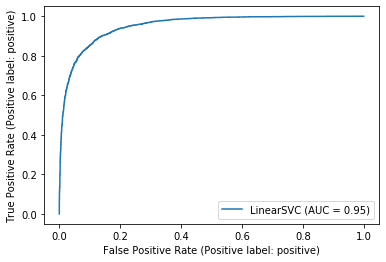

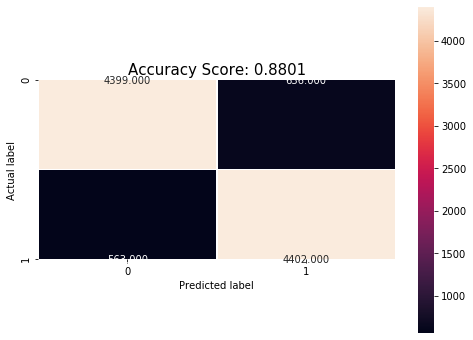

In [26]:
#Classification Report
print(classification_report(y_test, predictions_lsvc))

#ROC Curve
plt.figure(figsize=(8,6))
metrics.plot_roc_curve(lsvc, X_test, y_test) 
plt.show()

#Confusion Matrix of Results Classified by Linear SVC
plt.figure(figsize=(8,6))
sns.heatmap(cm_lsvc, annot=True, fmt=".3f", linewidths=.5, square= True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_lsvc)
plt.title(all_sample_title, size = 15)
plt.show()

**LinearSVC Classifier using CountVectorizer**

In [27]:
lsvc = LinearSVC()
lsvc.fit(X1_train, y1_train)
predictions_lsvc1 = lsvc.predict(X1_test)
score_lsvc1 = lsvc.score(X1_test, y1_test)
cm_lsvc1 = metrics.confusion_matrix(y1_test, predictions_lsvc1)

              precision    recall  f1-score   support

    negative       0.87      0.87      0.87      5035
    positive       0.86      0.87      0.87      4965

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



<Figure size 576x432 with 0 Axes>

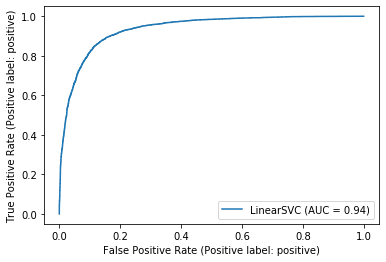

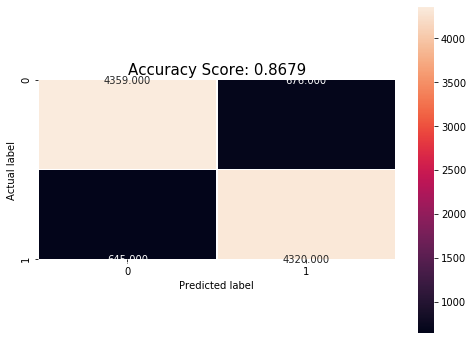

In [28]:
#Classification Report
print(classification_report(y1_test, predictions_lsvc1))

#ROC Curve
plt.figure(figsize=(8,6))
metrics.plot_roc_curve(lsvc, X1_test, y1_test) 
plt.show()

#Confusion Matrix of Results Classified by Linear SVC
plt.figure(figsize=(8,6))
sns.heatmap(cm_lsvc1, annot=True, fmt=".3f", linewidths=.5, square= True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_lsvc1)
plt.title(all_sample_title, size = 15)
plt.show()

**KNN Classification with TF-IDF**

In [29]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions_knn = knn.predict(X_test)
score_knn = knn.score(X_test, y_test)
cm_knn = metrics.confusion_matrix(y_test, predictions_knn)

              precision    recall  f1-score   support

    negative       0.80      0.69      0.74      5035
    positive       0.72      0.82      0.77      4965

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



<Figure size 576x432 with 0 Axes>

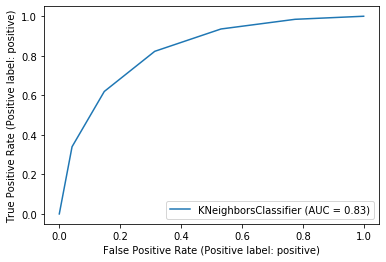

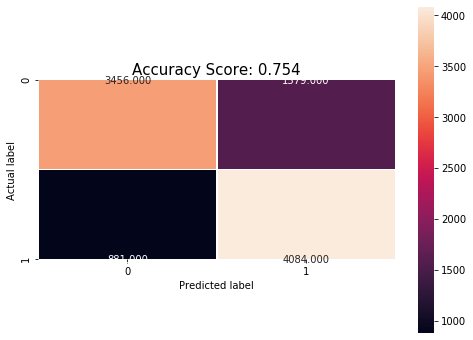

In [30]:
#Classification Report
print(classification_report(y_test, predictions_knn))

#ROC Curve
plt.figure(figsize=(8,6))
metrics.plot_roc_curve(knn, X_test, y_test) 
plt.show()

#Confusion Matrix of Results Classified by Linear SVC
plt.figure(figsize=(8,6))
sns.heatmap(cm_knn, annot=True, fmt=".3f", linewidths=.5, square= True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_knn)
plt.title(all_sample_title, size = 15)
plt.show()

**KNN Classification with CountVectorizer**

In [31]:
knn = KNeighborsClassifier()
knn.fit(X1_train, y1_train)
predictions_knn1 = knn.predict(X1_test)
score_knn1 = knn.score(X1_test, y1_test)
cm_knn1 = metrics.confusion_matrix(y1_test, predictions_knn1)

              precision    recall  f1-score   support

    negative       0.61      0.64      0.62      5035
    positive       0.62      0.59      0.60      4965

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



<Figure size 576x432 with 0 Axes>

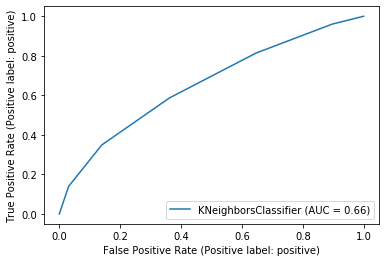

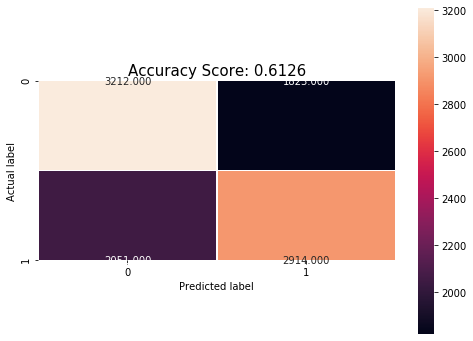

In [32]:
#Classification Report
print(classification_report(y1_test, predictions_knn1))

#ROC Curve
plt.figure(figsize=(8,6))
metrics.plot_roc_curve(knn, X1_test, y1_test) 
plt.show()

#Confusion Matrix of Results Classified by Linear SVC
plt.figure(figsize=(8,6))
sns.heatmap(cm_knn1, annot=True, fmt=".3f", linewidths=.5, square= True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_knn1)
plt.title(all_sample_title, size = 15)
plt.show()

**RESULTS**

In [35]:
table_cols = ['Classifiers','Accuracy w/ TF-IDF', 'AUC TF-IDF','Accuracy w/ CountVectorizer', 'AUC CountVectorizer']
classifiers = ['Logistic Regression','Multinomial Naive Bayes','Linear SVM', 'K-Nearest Neighbors']
accuracy_tfidf = [score_lr, score_mnb, score_lsvc, score_knn]
auc_tfidf = [.96,.93,.95,.83]
accuracy_count = [score_lr1, score_mnb1, score_lsvc1, score_knn1]
auc_count = [.95,.92,.95,.66]

myTable = PrettyTable()
myTable.add_column(table_cols[0], classifiers)
myTable.add_column(table_cols[1], accuracy_tfidf)
myTable.add_column(table_cols[2], auc_tfidf)
myTable.add_column(table_cols[3], accuracy_count)
myTable.add_column(table_cols[4], auc_count)
print(myTable)

+-------------------------+--------------------+------------+-----------------------------+---------------------+
|       Classifiers       | Accuracy w/ TF-IDF | AUC TF-IDF | Accuracy w/ CountVectorizer | AUC CountVectorizer |
+-------------------------+--------------------+------------+-----------------------------+---------------------+
|   Logistic Regression   |       0.8879       |    0.96    |            0.8808           |         0.95        |
| Multinomial Naive Bayes |       0.8545       |    0.93    |            0.8583           |         0.92        |
|        Linear SVM       |       0.8801       |    0.95    |            0.8679           |         0.95        |
|   K-Nearest Neighbors   |       0.754        |    0.83    |            0.6126           |         0.66        |
+-------------------------+--------------------+------------+-----------------------------+---------------------+


**REFERENCES**

https://www.youtube.com/watch?v=glHWiQRgLn4

https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data

https://www.youtube.com/watch?v=PvS4R1rTAs4

https://levelup.gitconnected.com/movie-review-sentiment-analysis-with-naive-bayes-machine-learning-from-scratch-part-v-7bb869391bab

https://towardsdatascience.com/a-guide-to-text-classification-and-sentiment-analysis-2ab021796317

https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a